In this notebook, we will learn 
- how to use pre-trained models to perform image classification. 
- We have already seen how we can train a simple neural network to classify images from the 10 Monkey Species dataset, but this was a relatively simple task since there were only ten classes. 
- On the other hand, classifying a larger number of object types will require much larger networks containing many millions of parameters. 
- Thanks to the `ImageNet` project, `pre-trained models are available in torchvision` that have been trained to detect objects from 1,000 different classes. 

![alt text](tensorflow-keras-imagenet-model-results-3.png)

## Table of Contents

* [1. ImageNet and ILSVRC](#1.-ImageNet-and-ILSVRC)
* [2. Pre-Trained Classification Models in Torchvision](#2.-Pre-Trained-Classification-Models-in-Torchvision)
* [3. Pre-Trained Model Setup](#3.-Pre-Trained-Model-Setup)
* [4. Make Predictions using the Pre-Trained Models](#4.-Make-Predictions-using-the-Pre-Trained-Models)
* [5. Conclusion](#5.-Conclusion)

## 1. ImageNet and ILSVRC
The [ImageNet](https://en.wikipedia.org/wiki/ImageNet) project is a `large visual database designed for visual object recognition software research`. The idea for this project was conceived over 15 years ago by AI researcher Fei-Fei Li. The ImageNet team presented their dataset for the first time in 2009.

Since 2010, the ImageNet project runs an annual software competition where research teams evaluate their computer vision algorithms for various visual recognition tasks such as Object Classification and Object Localization. The training data is a subset of ImageNet with 1.2 million images belonging to 1,000 [classes](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/). Deep Learning came to the limelight in 2012 when Alex Krizhevsky and his team won the competition by a margin of a whopping 11%. `ILSVRC and Imagenet are sometimes used interchangeably`.

There are various subsets of the ImageNet dataset used in various contexts. One of the most highly used subsets of ImageNet is the "ImageNet Large Scale Visual Recognition Challenge ([ILSVRC](https://www.image-net.org/challenges/LSVRC/)) 2012-2017 image classification and localization dataset". This is also referred to in the research literature as ImageNet-1K or ILSVRC2017, reflecting the original ILSVRC challenge that involved **1,000 classes**.


<img src="https://learnopencv.com/wp-content/uploads/2024/07/Imagenet.png" align='center'><br/>

In [1]:
# Make sure latest version is installed
# !pip install torchvision -q

In [2]:
from torchvision import models  # To load any classification model
from torchvision import transforms  # To apply PyTorch Transformations
from PIL import Image, ImageDraw, ImageFont

import os
import requests  # To download file
import cv2  # For annotating images
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt  # To visualize images

from zipfile import ZipFile
from urllib.request import urlretrieve

In [3]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)


URL = r"https://www.dropbox.com/s/8srx6xdjt9me3do/TF-Keras-Bootcamp-NB07-assets.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "PyTorch-Bootcamp-NB07-assets.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

## 2. Pre-Trained Classification Models in Torchvision
The winners of ILSVRC have been very generous in releasing their models to the open-source community. Many models are available in **Torchvision**, such as AlexNet, VGGNet, Inception, ResNet, Xception, and many more. Apart from the ILSVRC winners, many research groups also share their models, which they have trained for similar tasks, e.g., MobileNet, SqueezeNet, etc. All the models trained on ImageNet are for classifying images into one of 1,000 classes.

Torchvision comes bundled with many pre-trained classification models. As of torchvision version 0.19, there are 20 different pre-trained models available, where some versions contain many variants as well. The list of models can be found [here](https://pytorch.org/vision/stable/models.html#classification). Here we will use the following pre-trained models to make predictions on several sample test images.
- AlexNet
- VGG16
- ResNet18


To use any of the pre-trained models in Torchvision, there are four basic steps required:

1. Load a pre-trained model
2. Preprocess the input image(s) using `transforms`.
3. Forward pass the image to model to generate predictions.
4. De-code the predictions and map the `classnames` and `class_ids` on post-processing.

In [4]:
print(f"Available Models in TorchVision\n{dir(models)}")
print(f"Number of available models = {len(dir(models))}")

Available Models in TorchVision
['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X

## 3. Pre-trained Model Setup

### 3.1. Preprocess the Inputs
When these models were trained on the ImageNet dataset, the input images were preprocessed in a specific way. Besides `resizing` images to conform to the expected size of the network, the images are typically `zero-centered and normalized`. When using these models, it's important that your input images are pre-processed in the same way the training images were processed. For convenience, each model in torchvision includes a [transforms](https://pytorch.org/vision/0.9/transforms.html#torchvision-transforms).

Transforms are common image transformations. They can be chained together using [Compose](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose).

In [5]:
# Specify image transformations.
transform = transforms.Compose([
    # Resize the image to 256×256 pixels.
    transforms.Resize(256),

    # Crop the image to 224×224 pixels about the center.
    transforms.CenterCrop(224),

    # Convert the image to PyTorch Tensor data type.
    transforms.ToTensor(),
    
    # Normalize the image with imagenet mean and std.
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
# Download imagenet classes text file.
import requests

url = 'https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt'
output_file = 'imagenet_classes.txt'
response = requests.get(url=url)

if response.status_code == 200:
    with open(output_file, "w", encoding='utf-8') as file:
        file.write(response.text)
    print("File Downloaded Successfully ✅")
else:
    print(f"Failed to download file ❌, status code: {response.status_code}")

File Downloaded Successfully ✅


### 3.2. Instantiate the Model

Here we will use the [ResNet18](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#resnet18) model to describe the approach. Here we call the built-in model `resnet18()` to instantiate the ResNet18 pre-trained model. Notice that the function has several optional arguments, which provide a lot of flexibility for using the model. However, the default settings allow you to use the model right out of the box to perform image classification from 1,000 classes in the ImageNet dataset.


In [7]:
# Load ResNet Model
# models.resnet18(weights = "DEFAULT")
model = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# Load AlexNet Model
# model = models.alexnet(weights="DEFAULT")

# Load VGG16 Model
# model = models.vgg16(weights="DEFAULT")

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Put our model in eval mode to do inference
model.eval()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3.4. Forward Pass

After pre-processing the input images, we can then forward pass them to the model as shown below. Because PyTorch process image data in batches, we will need to add a batch dimension to the images, even if we process one image at a time. As an example, ResNet18 expects color images with a shape of `[3,224,224]`, but we must add a batch dimension so that the image batch has a shape: `[B, C, H, W]`, even if we intend to process a single image at a time. We'll see how this is done further below.

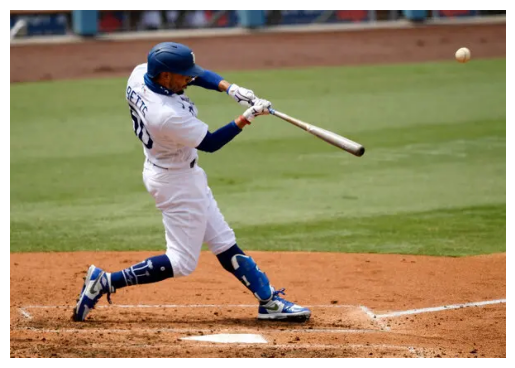

In [9]:
# Read the image
img = Image.open("images/baseball-player.png")

plt.imshow(img)
plt.axis("off")
plt.show()

In [10]:
img_transformed = transform(img)

# Add Batch Dimension [C, H, W] -> [B, C, H, W]
batch_transformed = torch.unsqueeze(img_transformed, 0) 

The ouput predictions returned will contain the class probabilities for all 1,000 classes as tensors.

In [ ]:
# Carry out inference
output = model(batch_transformed)
print(output.shape) # [B, num_classes]
print(output)

torch.Size([1, 1000])
tensor([[-1.4061e+00, -2.9384e+00, -2.2729e+00, -3.0935e+00, -3.8023e-01,
         -4.0457e+00, -3.3707e+00, -7.0278e-01, -2.4803e+00, -5.3530e-01,
         -7.8837e-01,  2.1813e+00, -6.7129e-01, -1.1164e+00,  3.3524e+00,
         -5.5987e-01, -5.9863e-01,  4.3879e+00,  2.7630e+00, -4.4714e-01,
         -3.8673e+00,  1.4285e+00, -1.9912e+00, -5.2142e-01, -2.7801e+00,
          1.6064e-01, -3.2357e+00, -3.0507e+00,  1.9389e-01, -3.5801e+00,
         -1.4842e+00,  1.6260e+00,  3.9362e-01, -1.0118e+00,  3.1380e+00,
          1.3439e-01,  2.1957e+00, -7.3350e-01,  9.4124e-02,  3.9806e-01,
          4.7780e-01, -9.5550e-01,  2.2098e+00, -1.7039e+00, -1.3384e+00,
          1.8172e+00,  4.0195e-01,  2.0965e-01, -3.2165e-01,  3.2517e+00,
          9.5082e-01, -3.9575e-01,  1.2189e+00,  2.1974e+00,  2.3216e+00,
         -9.0172e-01,  1.1909e+00, -3.3445e+00, -5.9211e-01, -9.9234e-01,
          1.7103e+00,  2.1318e+00,  1.8148e+00,  3.8787e+00, -4.8134e-01,
          2.5921

The following file [imagenet_classes.txt](https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt) contains all the IMAGENET class names.

In [12]:
# Load Labels
with open("imagenet_classes.txt") as file:
    classes = [line.strip() for line in file.readlines()]

In PyTorch, we can `decode the predictions returned by the model to get the top k predictions`. The process involves sorting the output probabilities in descending order and then `applying a softmax function` to get the `prediction percentages`.

* Use `torch.sort` to sort the output probabilities in `descending` order.
* Apply `torch.nn.functional.softmax` to `convert the output logits to probabilities.`
* Extract the top k predictions along with their class IDs and class descriptions.

In [14]:
_, indices = torch.sort(output, descending=True)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100

[ (classes[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('baseball', 69.17581176757812),
 ('ballplayer, baseball player', 30.808671951293945),
 ('racket, racquet', 0.010133982636034489),
 ('tennis ball', 0.0008962748106569052),
 ('soccer ball', 0.0005332775181159377)]

We will define a convenience utility function to visualise predictions using `cv2.putText()`.

In [16]:
def visualize_predictions(img, class_name, conf):
    """
    Function to visualize results:
    :param img: PIL Image
    :param class_name: Class name string
    :param conf: Prediction confidence string
    """
    bgr_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img_h, img_w = bgr_img.shape[:2]

    # Define font scale and thickness based on image height
    font_scale = max(0.003 * img_h, 0.5)
    thickness = max(1, int(img_h / 200))

    text = f"{class_name}, {conf}%"

    # Calculate text size to center it
    (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    text_x = (img_w - text_w) // 2
    text_y = (img_h + text_h) // 10

    cv2.putText(
        img=bgr_img,
        org=(text_x, text_y),
        text=text,
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        color=(0, 0, 255),
        fontScale=font_scale,
        thickness=thickness,
        lineType=cv2.LINE_AA
    )

    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.show()

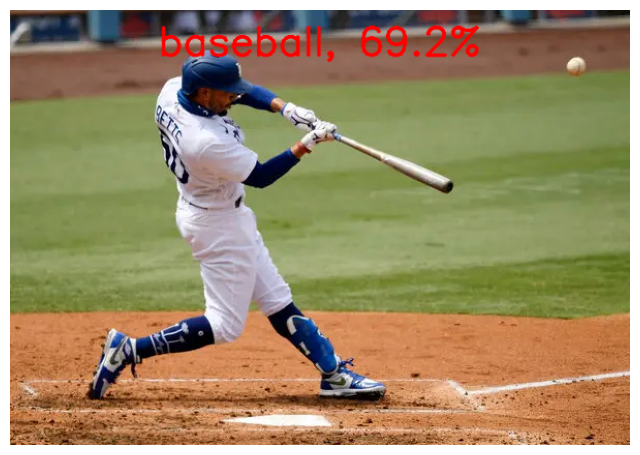

In [17]:
class_name = classes[indices[0][0]]
conf = f"{percentage[indices[0][0]].item():.1f}"
visualize_predictions(img, class_name, conf)

Finally we will iterate over all the images in a folder and plot the inference.

## 4. Make Predictions using the Pre-Trained Models

In [20]:
def make_prediction(img_path, model):
    model.eval()
    img = Image.open(img_path)
    img_transformed = transform(img).unsqueeze(0)
    output = model(img_transformed)
    _, indices = torch.sort(output, descending=True)
    percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
    [(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]
    class_name = classes[indices[0][0]].split(',')[0]
    conf = f"{percentage[indices[0][0]].item():.1f}"

    return img, class_name, conf

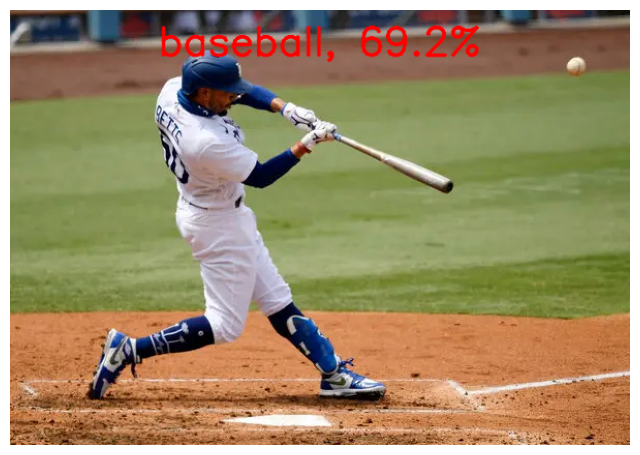

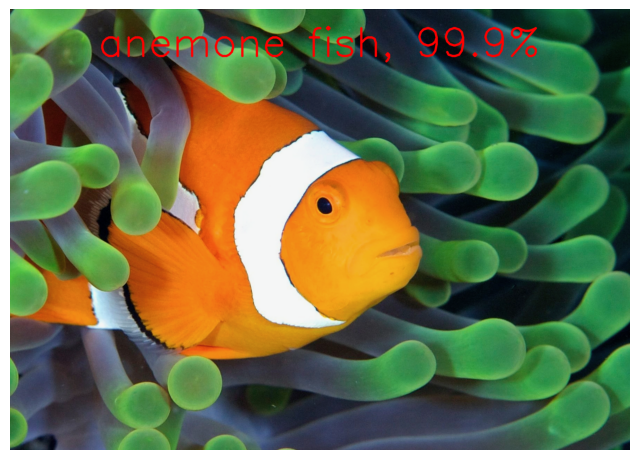

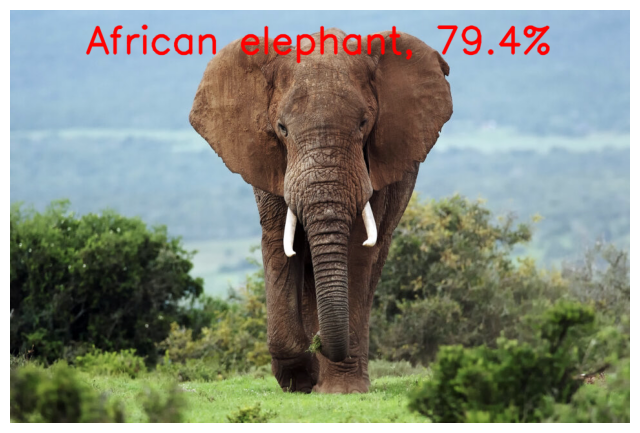

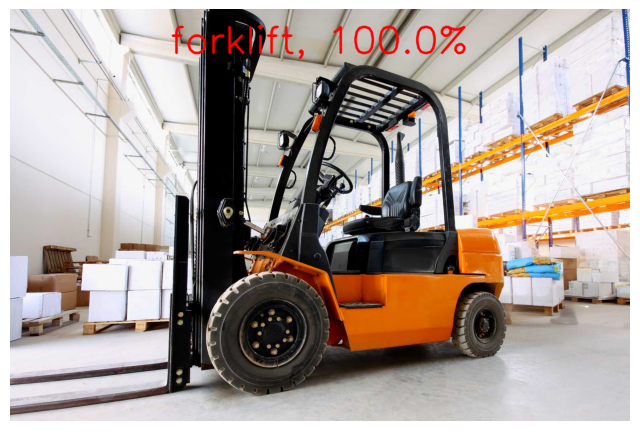

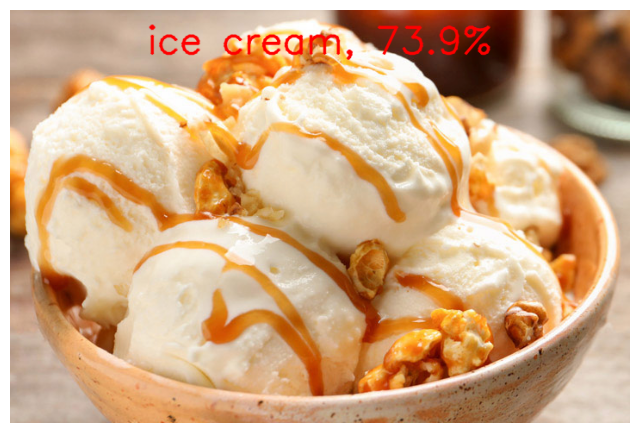

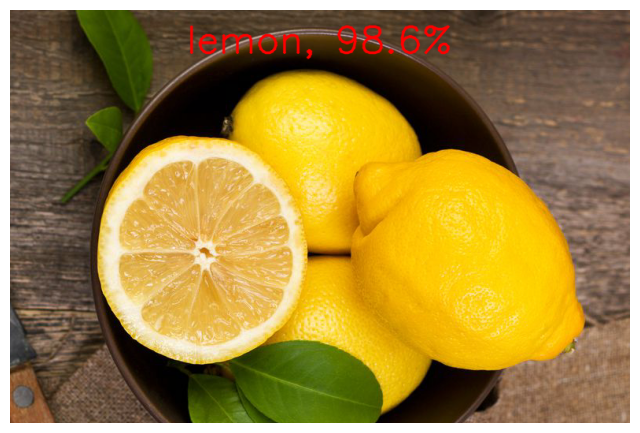

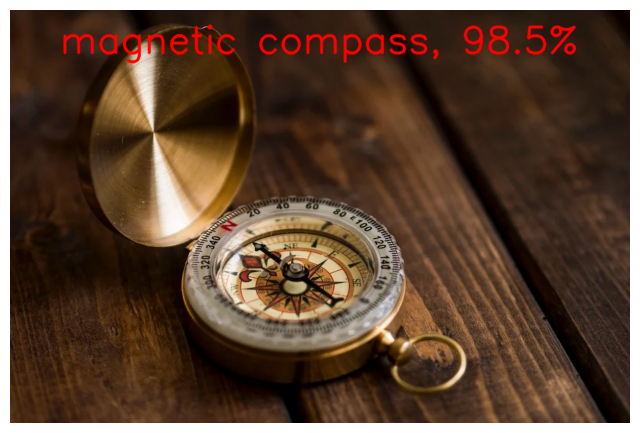

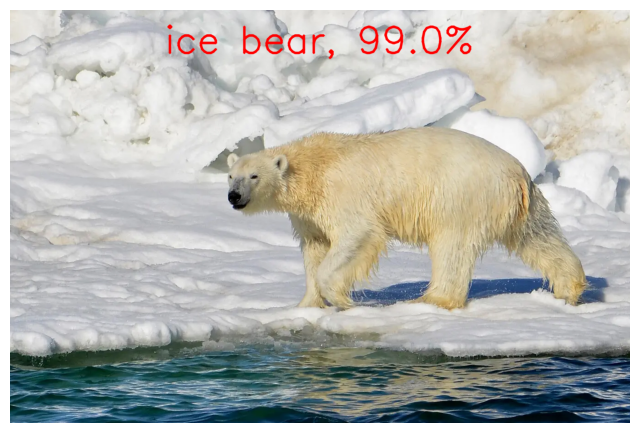

In [21]:
for img_path in os.listdir('images'):
    img_path = os.path.join("images", img_path)
    img, class_name, conf = make_prediction(img_path, model)
    visualize_predictions(img, class_name, conf)

There are 1,000 classes in the ImageNet dataset, and even though these are all very clear and distinct images, many share characteristics with other classes. Consequently, the model's top k predictions might still be relevant to the inference image, even if they are not the exact class.

For eg. the second highest probability prediction of magnetic compass image was stopwatch, which is relevant due to their shared visual features.

## 5. Conclusion

In this notebook, we learned how to `perform image classification using  pre-trained models in Torchvision`. In a subsequent notebook, you will learn more about leveraging pre-trained models to customize them for a particular application. This is a very common technique called **Transfer Learning**, where we `start with a pre-trained model and then re-trained a portion of the model with new images`. To make this more concrete, suppose you need to classify object types that do not exist in ImageNet. You can start with a pre-trained ImageNet model and then re-train a portion of the model using training images for the classes you are interested in. We will explore this topic in an upcoming notebook.

As an experiment, we encourage you to use this notebook to classify your own images and see how the models perform.